In [1]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns


from global_config import config
import pandas as pd
import numpy as np
import rpy2
import os

from datetime import date, timedelta

data_dir_mnps   = config.get_property('geo_dir')
data_dir        = config.get_property('data_dir')
fb_ppl_data     = config.get_property('covid_fb')
results_dir     = config.get_property('results_dir')
data_cases_path = os.path.join(fb_ppl_data, 'agglomerated', 'geometry')


In [3]:

# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab    = "Lockdown Imposed"


lockdowns = []
lockdowns.append({"code": "A",
                  "start_date" : pd.to_datetime("2020-07-13"),
                  "end_date"   : pd.to_datetime("2020-07-23"),
                  "places":["chapinero",
                            "los_martires",
                            "san_cristobal",
                            "tunjuelito",
                            "rafel_uribe_uribe",
                            "ciudad_bolivar",
                            "santa_fe",
                            "usme"]})

lockdowns.append({"code": "B",
                  "start_date" : pd.to_datetime("2020-07-23"),
                  "end_date"   : pd.to_datetime("2020-08-06"),
                  "places":["bosa",
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code": "C",
                  "start_date" : pd.to_datetime("2020-07-31"),
                  "end_date"   : pd.to_datetime("2020-08-14"),
                  "places":["suba",
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({
                  "code": "D",
                  "start_date" : pd.to_datetime("2020-08-16"),
                  "end_date"   : pd.to_datetime("2020-08-27"),
                  "places":["usaquen",
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})



In [34]:
from shapely.geometry import Point, LineString
from shapely.ops import cascaded_union

from datetime import timedelta
import contextily as ctx

import geopandas as gpd
from shapely import wkt

def read_geo_df(path_to_geodf):
    df_geo = pd.read_csv(path_to_geodf)
    df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)
    df_geo = gpd.GeoDataFrame(df_geo, geometry='geometry')

    return df_geo


all_data_df  = pd.read_csv(os.path.join(results_dir, "all_percentual_change_merged.csv"), parse_dates=["date"])
sse_info_df  = pd.read_csv(os.path.join(results_dir, "data", "censo", "variables.csv"))
shp_df       = gpd.read_file(os.path.join(results_dir, "data", "censo", "censo.shp"))
shp_df       = shp_df[['CODIGO_MZN', 'lat', 'lon', 'ESTRATO_MO', 'IPM', 'localidad', 'geometry']]
shp_df       = shp_df.dropna()

path_to_bog_polygon = os.path.join(data_dir_mnps, 'localities', 'localities_shapefile.shp')


# Read bogota polygons divided by localities.
polygons_bog = gpd.read_file( path_to_bog_polygon )
polygons_bog = polygons_bog.rename(columns={'location_i': 'location_id'})



In [39]:
for l in shp_df["localidad"].unique():
    a = shp_df[shp_df["localidad"]==l].describe()
    print(l, a)

Antonio Nariño               lat         lon         IPM
count  525.000000  525.000000  525.000000
mean     4.588416  -74.101712    6.423619
std      0.004724    0.008596    6.370748
min      4.576451  -74.127566    0.000000
25%      4.585003  -74.107136    1.800000
50%      4.589033  -74.100115    5.300000
75%      4.592288  -74.095227    9.200000
max      4.597747  -74.087068   58.800000
San Cristobal                lat          lon          IPM
count  2615.000000  2615.000000  2615.000000
mean      4.554926   -74.089453    15.079120
std       0.014356     0.007882    11.239107
min       4.517151   -74.105956     0.000000
25%       4.544677   -74.095521     7.300000
50%       4.556344   -74.089775    13.200000
75%       4.565170   -74.084247    20.300000
max       4.587983   -74.066284    85.000000
Usme                lat          lon          IPM
count  2782.000000  2782.000000  2782.000000
mean      4.506979   -74.108512    20.044896
std       0.014719     0.010023    15.716186
min

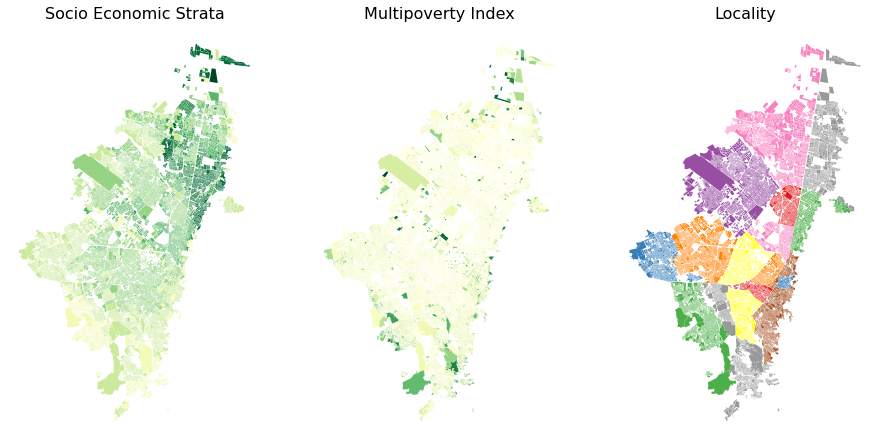

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15.5, 20.5))
#polygons_bog.plot(ax=ax[0], edgecolor='black', alpha=0.3, facecolor='white', linewidth=1)
#polygons_bog.plot(ax=ax[1], edgecolor='black', alpha=0.3, facecolor='white', linewidth=1)
#polygons_bog.plot(ax=ax[2], edgecolor='black', alpha=0.3, facecolor='white', linewidth=1)


# Plot values as linestring
shp_df.plot(ax=ax[0], column='ESTRATO_MO', cmap="YlGn")
shp_df.plot(ax=ax[1], column='IPM', cmap="YlGn")
shp_df.plot(ax=ax[2], column='localidad', cmap="Set1")

ax[0].set_title("Socio Economic Strata", fontsize = 16)
ax[1].set_title("Multipoverty Index", fontsize = 16)
ax[2].set_title("Locality", fontsize = 16)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()


In [6]:
def plot_sse(ipm_list, sse, sse_counts, locality=None):
    fig, ax = plt.subplots(1, 2, figsize=(15.5, 7.2))

    ax[0].bar(sse, sse_counts, facecolor='gray', edgecolor='k', alpha=0.5)
    ax[1].hist(ipm_list, facecolor='green', edgecolor='k', alpha=0.5, density=True)

    ax[0].set_title(f'Socio Economic Strata | {locality}')
    ax[1].set_title(f'Multipoverty Index | {locality}')


In [9]:
import seaborn as sns

localidades_list = shp_df.localidad.unique()

df_all_ipm = []
for loc in localidades_list:
    loc_shp = shp_df[shp_df.localidad==loc]

    ipm, ipm_counts = np.unique(loc_shp.IPM, return_counts=True)
    sse, sse_counts = np.unique(loc_shp.ESTRATO_MO, return_counts=True)

    ipm_df = pd.DataFrame(data=loc_shp.IPM, columns=["IPM"])
    plot_sse(loc_shp.IPM, sse, sse_counts, locality=loc)
    plt.close()



In [10]:
df_ipm = shp_df[["IPM", "localidad"]].rename(columns={"IPM": "x"})
df_ipm

,x,localidad
0,2.8,Antonio Nariño
1,3.8,Antonio Nariño
2,1.5,Antonio Nariño
3,9.4,Antonio Nariño
4,8.2,Antonio Nariño
...,...,...
43350,14.3,Suba
43351,6.8,Suba
43352,18.6,Suba
43353,20.4,Suba


In [17]:
df_ipm = df_ipm[df_ipm["x"]>20]
df_ipm

,x,localidad
22,25.9,San Cristobal
23,29.7,San Cristobal
25,76.9,San Cristobal
29,26.7,San Cristobal
30,23.9,San Cristobal
...,...,...
43296,20.3,Suba
43297,20.6,Suba
43319,36.8,Suba
43344,23.7,Suba


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


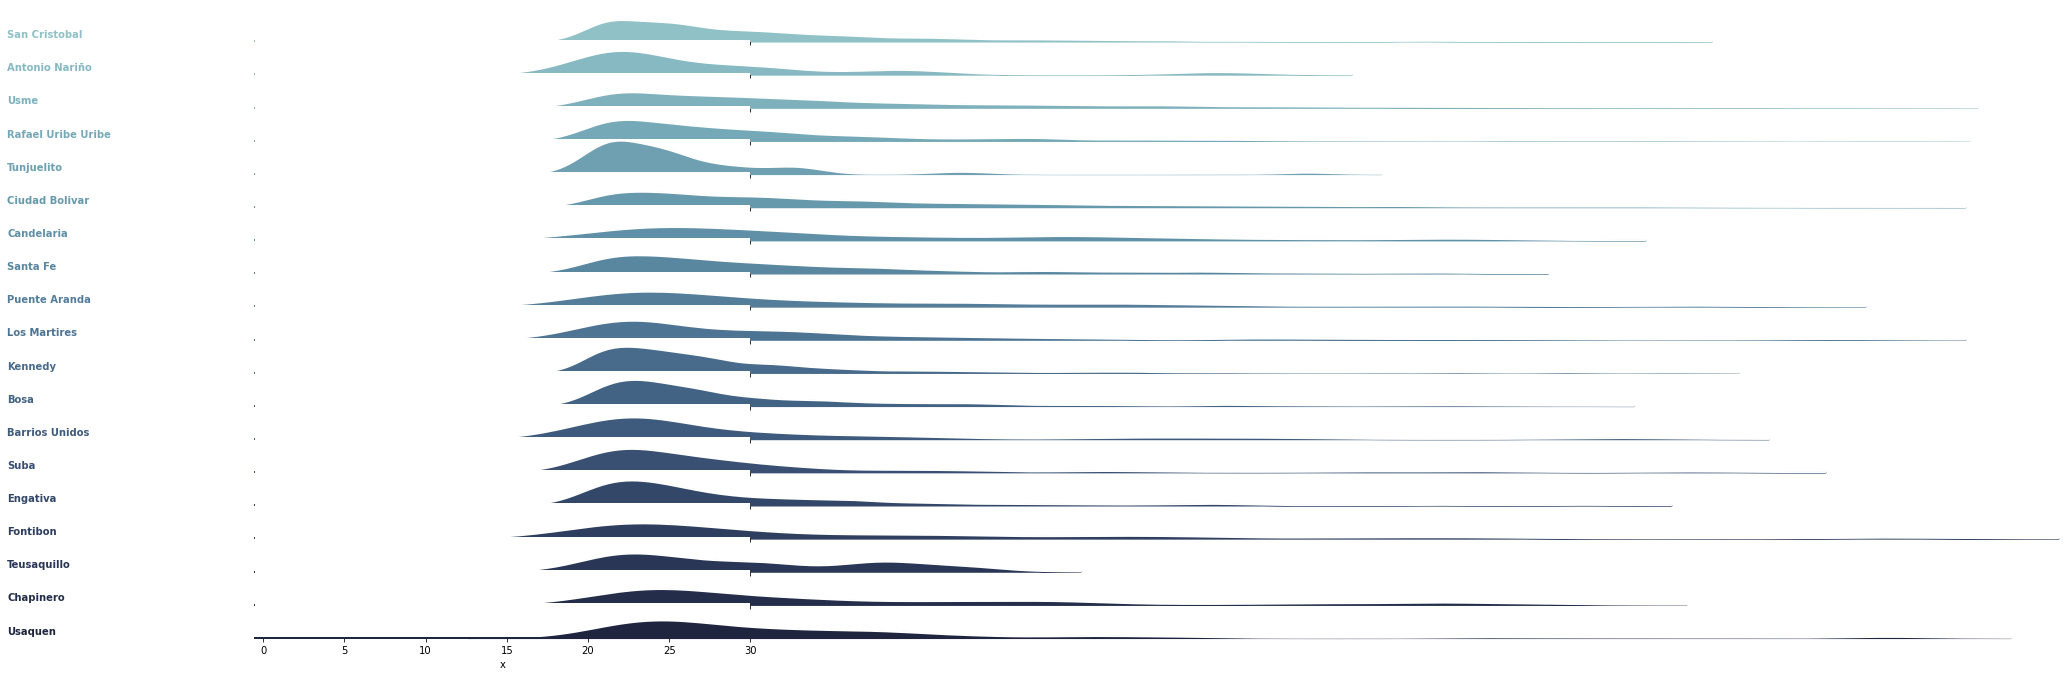

In [18]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(df_ipm.localidad.unique().shape[0], rot=-.25, light=.7)
g   = sns.FacetGrid(df_ipm, row="localidad", hue="localidad", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.5, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    ax.set_xlim([-0.5, 30])

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.05)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)


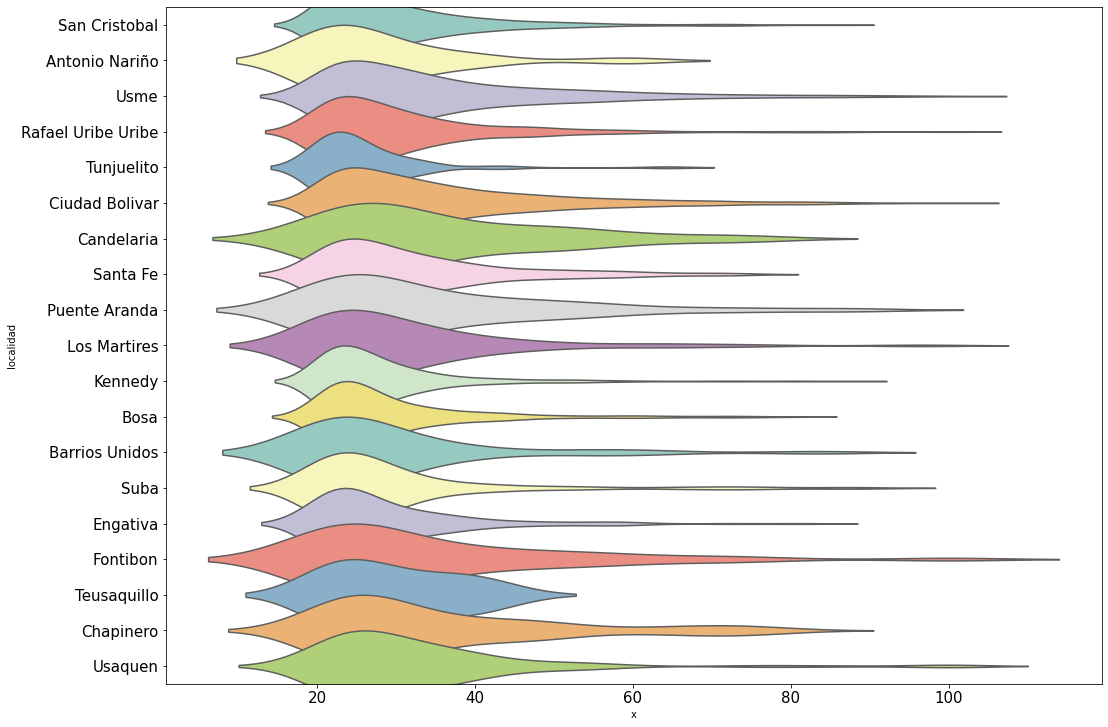

In [19]:
fig, ax = plt.subplots(1,1,figsize=(15.5, 10.2))

sns.violinplot(x="x", y="localidad",
            data=df_ipm,
            scale="width", palette="Set3", inner=None,
            height=15.5, width=2, ax =ax, trim=True)
ax.tick_params(axis='both', labelsize=15)
plt.tight_layout()


<ipython-input-21-7287707aa9cf>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


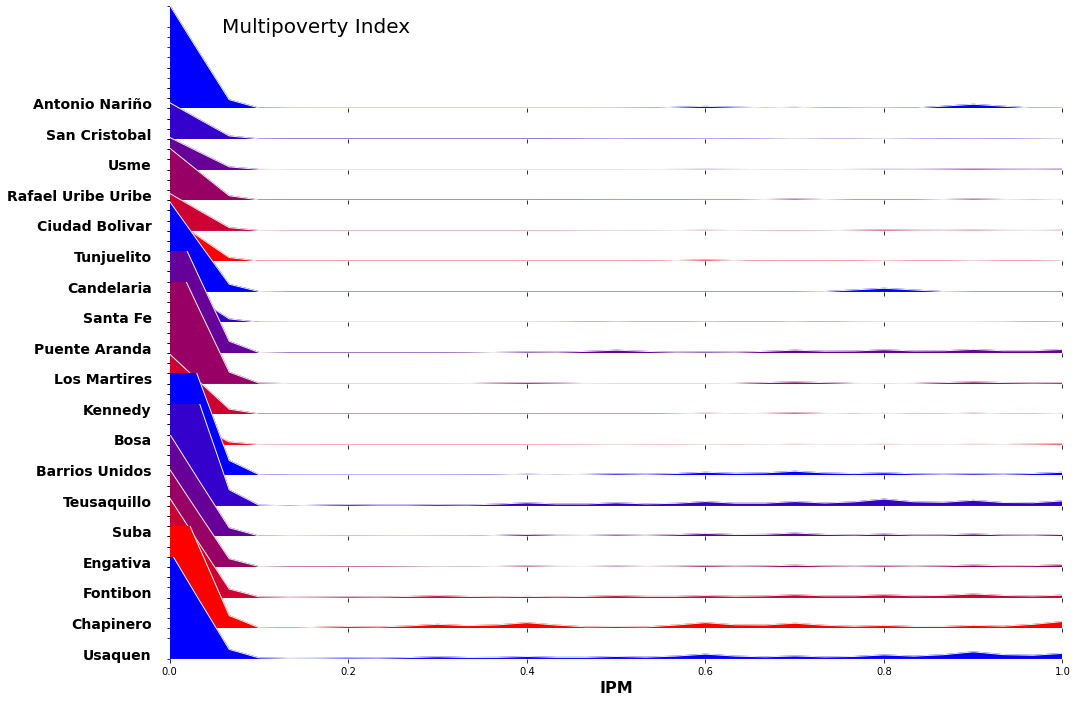

In [21]:
from sklearn.neighbors import KernelDensity

import matplotlib.gridspec as grid_spec
import matplotlib.pyplot as plt
import matplotlib as mpl


colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000', '#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000',
            '#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000', '#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']


localidades_list = shp_df.localidad.unique()

gs = grid_spec.GridSpec(len(localidades_list),1)
fig = plt.figure(figsize=(16, 12))

i = 0

ax_objs = []
for loc in localidades_list:
    x = np.array(shp_df[shp_df.localidad == loc].IPM)
    x_d = np.linspace(0,100, 3000)

    kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,1)
    ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(localidades_list)-1:
        ax_objs[-1].set_xlabel("IPM", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top", "right", "left", "bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_country = loc.replace(" ","\n")
    ax_objs[-1].text(-0.02,0, loc,fontweight="bold",fontsize=14,ha="right")
    i += 1

gs.update(hspace=-0.7)

fig.text(0.17,0.85, "Multipoverty Index", fontsize=20)

plt.tight_layout()
plt.show()